# L'analisi dei dati di Twitter

strumento potente per capire l'opinione pubblica su un argomento. I tweet possono rivelare sentimenti, temi ricorrenti e tendenze, e sono quindi una risorsa preziosa per il data storytelling.

* tweet ed utenti piu influenti

Qui analizziamo il dataset https://www.kaggle.com/datasets/fifthtribe/how-isis-uses-twitter costituito dalle conversazioni di 100 utenti pro ISIS, le conversazioni che generano sono veramente a favore o contro l'organizzazione??


# Scarichiamo le librerie necessarie

* together: per usare LLM
* bertopic: per clusterizzare i testi
* python-louvain: per clusterizzare nodi di reti

In [4]:
!pip install together -q


In [5]:
!pip install bertopic -q

In [6]:
!pip install --user python-louvain  -q


# Apertura dati

* NB qui presi da drive, modifica i percorsi

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd

In [10]:
df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/OSINTItalia/tweets.xlsx')

df

,name,username,description,location,followers,numberstatuses,time,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
...,...,...,...,...,...,...,...,...
17405,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:46,#Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17406,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:50,#Breaking\n\n Iraqi forces bulldozer destroyed...
17407,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:51,#Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 16:07,#PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...


#Analisi dei grafi: individuare gli utenti più influenti e le community

Un grafo è una rappresentazione di dati in cui:
* Nodi: rappresentano entità (nel nostro caso, utenti di Twitter).
* Archi: rappresentano relazioni tra i nodi (es. menzioni, retweet o interazioni).
Questa struttura è particolarmente utile per analizzare reti sociali, in cui possiamo studiare:

1. L'influenza degli utenti: Chi è più centrale o connesso nella rete?
2. Le community: Gruppi di utenti che interagiscono più frequentemente tra loro.

In [11]:
import networkx as nx
from community import community_louvain  # Per il clustering
import re  # Per lavorare con le espressioni regolari


In [14]:
# Estrarre le menzioni dai tweet
mentions = []
for tweet in df['tweets']:
    men = re.findall("@(\w+)", str(tweet))  # Trova tutte le menzioni (@username) in ogni tweet
    mentions.append(men)

# Aggiungere una colonna con le menzioni al DataFrame
df['Mentions'] = mentions

# Visualizzare i tweet che contengono almeno una menzione
df[df['Mentions'].astype(str) != '[]'][['username','tweets','Mentions']].sample(5).head()

,username,tweets,Mentions
8921,thefIamesofhaqq,RT @Free_lance_jour: Reminder:\nThis happened ...,[Free_lance_jour]
16218,mobi_ayubi,RT @Malcolmite: Confirmed: Syrian Rebels captu...,[Malcolmite]
8513,Uncle_SamCoco,@FranceTn @_DavidThomson le savoir français e...,"[FranceTn, _DavidThomson]"
443,warreporter2,@AbuIzzadeen2 https://t.co/zCeIsz2dd8,[AbuIzzadeen2]
1681,Abu_Azzzam25,RT @AbuNaseeha_03: #Israel Defence Forces are ...,[AbuNaseeha_03]


In [ ]:
# Creare una lista di sorgenti, destinazioni e pesi degli archi
sources = []
targets = []
edges = {}  # Dizionario per salvare i pesi degli archi

for row in df.iterrows():
    source = str(row[1]["username"])  # Utente che scrive il tweet
    targets = str(row[1]["Mentions"])  # Utenti menzionati
    if targets != '[]':  # Consideriamo solo tweet con menzioni
        for target in targets.split(","):
            target = re.sub(r'[^\w\s]', ' ', target).strip()  # Rimuovere punteggiatura e spazi bianchi
            weight = (source, str(target))  # Crea una tupla (sorgente, destinazione)
            if weight in edges:  # Incrementa il peso se l'arco esiste
                edges[weight] += 1
            else:  # Altrimenti, inizializza il peso a 1
                edges[weight] = 1

# Stampare un esempio di arco con il suo peso
for knot, weight in edges.items():
    print(knot, '|', weight)
    break

('GunsandCoffee70', 'KhalidMaghrebi') | 2


In [ ]:
# Creare un grafo diretto
DG = nx.DiGraph()
for k, v in edges.items():
    source = k[0]
    target = k[1]
    weight = v
    DG.add_edge(source, target, weight=weight)  # Aggiungere l'arco al grafo con il peso


In [ ]:
# Calcolare la centralità di PageRank
page_rank_dict = nx.pagerank(DG)  # Esegue l'algoritmo di PageRank

# Assegnare il PageRank come attributo ai nodi
nx.set_node_attributes(DG, page_rank_dict, 'pagerank centrality')

# Salvare i risultati in un DataFrame temporaneo
tmp = pd.DataFrame(list(zip(page_rank_dict.keys(), page_rank_dict.values())),
                   columns=['username', 'pagerank'])

# Aggiungere i valori di PageRank al DataFrame originale
df = df.merge(tmp, how='left', on='username')


In [ ]:
# Ordinare il DataFrame per PageRank in ordine decrescente
df_sorted = df.sort_values(by='pagerank', ascending=False)

# Rimuovere eventuali duplicati basandosi su 'username'
unique_top_users = df_sorted.drop_duplicates(subset='username').head(5)

# Stampare i top 5 utenti univoci con i loro tweet
print("Top 5 utenti univoci con il punteggio più alto di PageRank:")
for idx, row in unique_top_users.iterrows():
    print(f"Username: {row['username']}")
    print(f"PageRank: {row['pagerank']:.4f}")
    print(f"Tweet: {row['tweets']}")
    print("-" * 50)  # Separatore per leggibilità


Top 5 utenti univoci con il punteggio più alto di PageRank:
Username: RamiAlLolah
PageRank: 0.0015
Tweet: .@Mohammed_Aloush اللي جابكم على جنيف عم ينجرللكم الخازوق بقا حضروا حالكم..
--------------------------------------------------
Username: btt_ar
PageRank: 0.0009
Tweet: 🎥#WilayatDijlah
■||" Their #Assembly will be #Defeated, and They will Show Their Back "||
All links ⤵️
https://t.co/MNJYY0r7Wq
--------------------------------------------------
Username: Al_Battar_Engl
PageRank: 0.0009
Tweet: Aspects of the work of center services - the construction of a park for children in the area of mansions #Mosul
https://t.co/XmEwfjfB63
--------------------------------------------------
Username: fahadslay614
PageRank: 0.0008
Tweet: please follow and support my account
@fahadslay614 
@fahadslay614 
@fahadslay614 
@fahadslay614
--------------------------------------------------
Username: mustaklash
PageRank: 0.0007
Tweet: Medical test laboratories in the city of AlBuKamal

[Full Album] https://

#Cluster di utenti con Louvain: Identificare le community

L'algoritmo di Louvain è uno dei metodi più utilizzati per il rilevamento delle community in reti complesse. Funziona ottimizzando la modularità, una misura che valuta la densità delle connessioni all'interno di un gruppo rispetto alle connessioni tra gruppi diversi.

dentificazione delle community:
Scoprire gruppi di utenti che interagiscono frequentemente tra loro.
Identificare gruppi tematici o reti di interesse comune.
Supporto alle strategie di engagement:
Trovare cluster di utenti per strategie di comunicazione mirate.
Visualizzazione della struttura sociale:
Osservare come gli utenti si connettono e si raggruppano nella rete.

In [ ]:
%%time

# Convertire il grafo diretto in un grafo non diretto
G = DG.to_undirected()

# Applicare l'algoritmo di Louvain
partition = community_louvain.best_partition(G, resolution=2)

# Generare una posizione per visualizzare il grafo
pos = nx.spring_layout(G)

# Ottenere un set delle community rilevate
communities_louvain = set(partition.values())

# Creare un dizionario che mappa i numeri delle community agli utenti che ne fanno parte
communities_louvain_dict = {
    c: [k for k, v in partition.items() if v == c] for c in communities_louvain
}

# Assegnare le community come attributo ai nodi del grafo
nx.set_node_attributes(DG, partition, 'community_louvain')

# Salvare le community in un DataFrame temporaneo
tmp = pd.DataFrame(list(zip(partition.keys(), partition.values())),
                   columns=['username', 'community_louvain'])

# Unire le informazioni sulle community al DataFrame originale
df = df.merge(tmp, how='left', on='username')

# Stampare i risultati
df.head()


CPU times: user 58.3 s, sys: 158 ms, total: 58.5 s
Wall time: 1min 14s


,name,username,description,location,followers,numberstatuses,time,tweets,Mentions,pagerank,community_louvain
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:07:00,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...,[],0.000291,0.0
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:27:00,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...,[],0.000291,0.0
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:29:00,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...,[],0.000291,0.0
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:37:00,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...,[],0.000291,0.0
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,2015-01-06 21:45:00,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...,[],0.000291,0.0


In [ ]:
df.to_excel('/content/drive/MyDrive/Colab_Notebooks/OSINTItalia/tweets_topic.xlsx')
nx.write_gexf(DG, f"/content/drive/MyDrive/Colab_Notebooks/OSINTItalia/tweets_topic_rete.gexf")

# BERTopic

libreria avanzata per l'estrazione di temi (topic modeling) da documenti testuali. BERTopic sfrutta modelli di embedding pre-addestrati basati su reti neurali per rappresentare i documenti in uno spazio vettoriale, garantendo maggiore precisione e flessibilità. Questo approccio consente:

* Riconoscimento di temi più complessi: Identifica temi anche quando il linguaggio è vario e non strutturato, come nei tweet.
* Supporto multilingua: Può lavorare con lingue diverse grazie a modelli di embedding ottimizzati per il multilingua.
* Interpretabilità: Fornisce una lista di termini chiave per ogni tema, aiutandoci a comprendere meglio i dati.

Cosi possiamo

1. Classificare automaticamente i tweet in temi: Scoprire di cosa parlano gli utenti.
2. Identificare i termini chiave per ciascun tema: Capire il "cuore" del discorso.
3. Esplorare la distribuzione dei temi: Valutare quanto ogni argomento è rappresentato nei dati.

In [ ]:
%%time

# Importare BERTopic
from bertopic import BERTopic

# Preparare i dati
# Convertire la colonna 'tweets' del DataFrame in una lista di documenti (uno per ogni tweet).
docs = df['tweets'].tolist()

# Creare il modello BERTopic
# La variante "paraphrase-MiniLM-L3-v2" è più leggera rispetto a modelli più grandi.
topic_model = BERTopic(embedding_model="paraphrase-MiniLM-L3-v2")

# Applico il modello
topics, probs = topic_model.fit_transform(docs)
df['Topic']=topics

# Stampare i temi principali
print("Temi principali identificati:")
display(topic_model.get_topic_info())

Temi principali identificati:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,8531,-1_the_in_of_is,"[the, in, of, is, to, rt, isis, and, https, co]","[RT @MaghrebiRDC: In the same time, you see fa..."
1,0,582,0_co_https_دعم_ha,"[co, https, دعم, ha, this, lol, ameen, here, r...","[دعم\n\nhttps://t.co/ByCERNOtMp, Ha ha ha http..."
2,1,542,1_de_le_la_est,"[de, le, la, est, les, je, des, pas, et, un]",[@wail75q le coté je m'en fou des massacres n'...
3,2,256,2_aleppo_rebels_north_northern,"[aleppo, rebels, north, northern, thearabsourc...",[RT @markito0171: #Syria Bad night for rebels ...
4,3,230,3_في_من_الله_على,"[في, من, الله, على, بسم, الدولة, الرحمن, الرحي...",[RT @SearcherV: مقتل اكثر من ٣٠ عنصر من الجيش ...
...,...,...,...,...,...
189,188,10,188_brussels_maelbeek_americans_dead,"[brussels, maelbeek, americans, dead, metro, 3...",[RT @AP: Latest on Belgium attacks: Brussels p...
190,189,10,189_jets_marines_thevictoryseri4_kczkprwlqq,"[jets, marines, thevictoryseri4, kczkprwlqq, b...",[RT @BlogsofWar: Iran unveils new «Bahman» 57...
191,190,10,190_egypt_egyptian_yytfli2qup_cnnsport,"[egypt, egyptian, yytfli2qup, cnnsport, nrgiki...",[RT @L0gg0l: Unconfirmed reports from Egypt th...
192,191,10,191_umar_khurasani_bvhxsnjeak_kh6u7dvmqe_mld3l...,"[umar_khurasani, bvhxsnjeak, kh6u7dvmqe, mld3l...","[RT @umar_khurasani: https://t.co/mld3LBBCMo, ..."


CPU times: user 6min 15s, sys: 1.44 s, total: 6min 16s
Wall time: 6min 23s


Le WordCloud sono una rappresentazione grafica delle parole più frequenti o significative associate a un tema. Le parole più grandi rappresentano quelle con maggiore importanza o frequenza. Questa visualizzazione è particolarmente utile per:

Esplorare rapidamente i contenuti di un tema.
Comunicare in modo chiaro i concetti principali a un pubblico.

Domande per gli studenti
Cosa rappresentano le dimensioni delle parole?

Più grande è una parola, più importante o frequente è nel tema.
Come possiamo usare queste WordCloud?

Per raccontare una storia visiva sui temi dominanti nei dati.
Per spiegare rapidamente il contenuto dei dati a un pubblico non tecnico.

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8829,-1_the_is_in_to,"[the, is, in, to, isis, of, and, rt, https, co]","[No matter what others may put on you, forgive..."
1,0,544,0_de_le_la_est,"[de, le, la, est, les, je, des, pas, et, un]",[@Annabbii mais croire que Janviériste sont de...
2,1,518,1_co_https_دعم_ha,"[co, https, دعم, ha, ameen, lol, this, read, l...","[Ha ha https://t.co/m7kisZ4500, Ha ha ha http..."
3,2,222,2_في_من_على_الله,"[في, من, على, الله, بسم, الدولة, الرحمن, الرحي...",[RT @ABUHIBBAN9: بسم الله الرحمن الرحيم \n\nال...
4,3,207,3_aleppo_rebels_north_northern,"[aleppo, rebels, north, northern, map, syria, ...",[RT @Buzzriet: #Syria #Aleppo\nAnd another att...
...,...,...,...,...,...
192,191,10,191_haneefah_rulers_rebellion_supported,"[haneefah, rulers, rebellion, supported, imam,...",[Imam Abu Haneefah's views about fighting rule...
193,192,10,192_muslims_mosque_unite_muslimfromchina,"[muslims, mosque, unite, muslimfromchina, chin...",[RT @MuslimPrisoners: Muslims inviting society...
194,193,10,193_units_infiltrate_kurdish_shuyukh,"[units, infiltrate, kurdish, shuyukh, kobani, ...",[#Breaking 3 Kurdish units killed yesterday as...
195,194,10,194_manjanik_news_siyono_hanya_yang,"[manjanik_news, siyono, hanya, yang, bisa, kep...","[RT @manjanik_news: Tak Hanya Ustadz Ba’asyir,..."


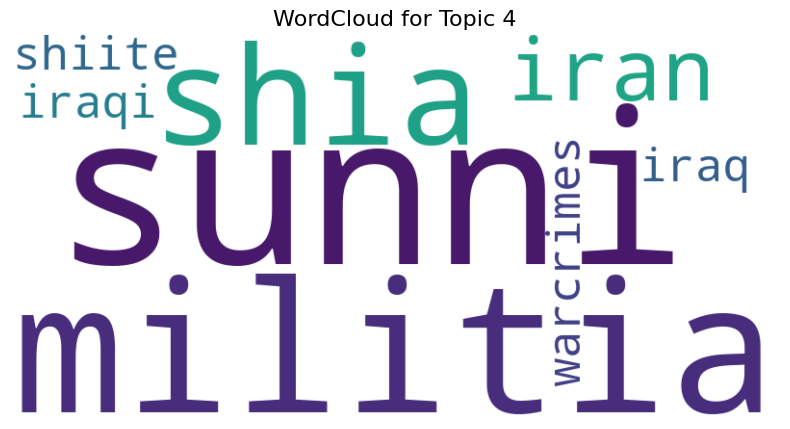

In [ ]:
from wordcloud import WordCloud
# Specifica il topic di interesse
topic_id = 4   # Scegli il topic che vuoi visualizzare

# Supponiamo che df_topics sia un DataFrame restituito da BERTopic con colonne come 'Topic' e 'Representation'.
# La colonna 'Representation' contiene le parole chiave del tema come una stringa separata da spazi.
df_topics = topic_model.get_topic_info()
display(df_topics)
topic_words = df_topics.loc[df_topics["Topic"] == topic_id, "Representation"].values[0]

# Creazione della WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(topic_words))

# Visualizzazione della WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f"WordCloud for Topic {topic_id}", fontsize=16)
plt.show()

# Introduzione a Huggingface

Huggingface è una delle piattaforme più popolari per l'elaborazione del linguaggio naturale (NLP). Offre una vasta gamma di modelli pre-addestrati che possono essere utilizzati per diverse applicazioni, come:

* Riassunti (Summarization)
* Traduzioni (Translation)
* Risposte a domande (Question Answering)
* Classificazioni di testi (Text Classification)
* Generazione di testi (Text Generation)

In questo esempio, esploreremo il task di summarization (riassunto) utilizzando un modello pre-addestrato chiamato facebook/bart-large-cnn. Questo modello è stato addestrato per creare riassunti di testi lunghi.

Perché Huggingface?
Accessibilità:
Con pochi comandi, puoi scaricare e utilizzare modelli pre-addestrati.
Personalizzazione:
Puoi scegliere tra migliaia di modelli disponibili per diverse lingue e compiti.
Flessibilità:
Supporta molteplici framework, come PyTorch e TensorFlow.
Community:
Una vasta community di sviluppatori contribuisce regolarmente con modelli e dataset.

In [ ]:
%%time
from transformers import pipeline

# Inizializza il pipeline di summarization
# Utilizziamo il modello "facebook/bart-large-cnn", pre-addestrato per creare riassunti di testi lunghi.
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")



config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

CPU times: user 4.93 s, sys: 6.25 s, total: 11.2 s
Wall time: 29.7 s


In [ ]:

# Filtra i testi per il topic selezionato
# Selezioniamo un topic specifico dai dati, identificato dal numero 'topic_id'.
topic_id = 2  # Identifica il numero del tema (sostituire con l'ID del topic desiderato)

# Filtriamo i tweet associati al topic scelto dal DataFrame e li trasformiamo in una lista di testi.
topic_texts = df.loc[df["Topic"] == topic_id, "tweets"]
topic_texts = topic_texts.dropna()  # Rimuove eventuali valori nulli.
topic_texts = topic_texts.drop_duplicates()  # Rimuove testi duplicati per evitare ridondanza.
topic_texts = topic_texts.tolist()  # Trasforma la colonna filtrata in una lista di stringhe.

# Sottocampione casuale rispettando il limite di caratteri
# Combiniamo i tweet filtrati in un unico testo fino a raggiungere un massimo di 1000 caratteri.
combined_text = ""  # Inizializziamo il testo combinato vuoto.
for text in topic_texts:
    if len(combined_text) + len(str(text)) <= 1000:  # Controlliamo di non superare il limite di 1000 caratteri.
        combined_text += " " + str(text)  # Aggiungiamo il tweet al testo combinato.
    else:
        break  # Interrompiamo l'aggiunta quando il limite è raggiunto.

# Suddividi il testo combinato in blocchi di massimo 1024 token
# I modelli come "facebook/bart-large-cnn" hanno un limite di input di 1024 token.
chunk_size = 1024  # Impostiamo la dimensione massima del blocco.
# Dividiamo il testo combinato in blocchi più piccoli, ciascuno di dimensione chunk_size.
text_chunks = [combined_text[i:i+chunk_size] for i in range(0, len(combined_text), chunk_size)]

# Applica il riassunto a ciascun blocco
# Iteriamo su ciascun blocco di testo e applichiamo il modello di summarization.
summaries = []  # Lista per memorizzare i riassunti di ogni blocco.
for chunk in text_chunks:
    # Generiamo un riassunto per il blocco corrente.
    # Utilizziamo parametri per controllare la lunghezza minima e massima del riassunto.
    summary = summarizer(chunk.strip(), max_length=130, min_length=30, do_sample=False)[0]['summary_text']
    summaries.append(summary)  # Aggiungiamo il riassunto alla lista.

# Combina i riassunti
# Uniamo i riassunti di tutti i blocchi in un unico testo.
final_summary = " ".join(summaries)

# Stampa il risultato finale
# Presentiamo il riassunto completo che sintetizza i testi del topic selezionato.
print("Riassunto Finale:")
print(final_summary)


Riassunto Finale:
Twitter users share their thoughts on Muslims eating Halal meat. @abdelhakzait: Why Do Muslims Eat Halal Meat? #Hamza_sy9:  ‘#Hamza’s’ #HalalMeat is the most popular meat eaten by Muslims in the world.


In [ ]:
# Lista di topic_ids
topic_ids = [0, 1, 2,3,4]  # Sostituisci con gli ID dei topic desiderati.

# Inizializza un dizionario per memorizzare i riassunti per ciascun topic
topic_summaries = {}

# Itera su ciascun topic_id nella lista
for topic_id in topic_ids:
    print(f"Processing Topic ID: {topic_id}")

    # Filtra i tweet associati al topic corrente dal DataFrame
    topic_texts = df.loc[df["Topic"] == topic_id, "tweets"]
    topic_texts = topic_texts.dropna()  # Rimuove eventuali valori nulli.
    topic_texts = topic_texts.drop_duplicates()  # Rimuove testi duplicati.
    topic_texts = topic_texts.tolist()  # Trasforma la colonna filtrata in una lista di stringhe.

    # Sottocampione casuale rispettando il limite di caratteri
    combined_text = ""  # Inizializziamo il testo combinato vuoto.
    for text in topic_texts:
        if len(combined_text) + len(str(text)) <= 1000:  # Controlla di non superare il limite di 1000 caratteri.
            combined_text += " " + str(text)  # Aggiunge il tweet al testo combinato.
        else:
            break  # Interrompe l'aggiunta quando il limite è raggiunto.

    # Suddividi il testo combinato in blocchi di massimo 1024 token
    chunk_size = 1024  # Imposta la dimensione massima del blocco.
    text_chunks = [combined_text[i:i+chunk_size] for i in range(0, len(combined_text), chunk_size)]

    # Applica il riassunto a ciascun blocco
    summaries = []  # Lista per memorizzare i riassunti di ogni blocco.
    for chunk in text_chunks:
        # Genera un riassunto per il blocco corrente.
        summary = summarizer(chunk.strip(), max_length=130, min_length=30, do_sample=False)[0]['summary_text']
        summaries.append(summary)  # Aggiungi il riassunto alla lista.

    # Combina i riassunti
    final_summary = " ".join(summaries)

    # Salva il riassunto finale per il topic corrente
    topic_summaries[topic_id] = final_summary

# Stampa i riassunti finali per ciascun topic
for topic_id, summary in topic_summaries.items():
    print(f"\nRiassunto per Topic ID {topic_id}:")
    print(summary)

Processing Topic ID: 0
Processing Topic ID: 1
Processing Topic ID: 2
Processing Topic ID: 3
Processing Topic ID: 4

Riassunto per Topic ID 0:
L'EI ampute la main d'un homme accusé de vol. @Serdariqritiya pas sur les dernières années en tout cas. @Slamiste68 @BarbeCourte avant que la Qibla soit à Mekka elle était à Al Qods. @Mundafen2 ils menacent de le faire, ils sont pas en train of le faire. @AleveryJunior @_DavidThomson la vidéo de la province Ninive avec le bourreau au cheveux

Riassunto per Topic ID 1:
The word of the week is #IS #Doma. Read these tweets&gt;following https://t.co/H43FeE7IiL YESSSPROUDLY WE ARE.

Riassunto per Topic ID 2:
Twitter users share their thoughts on Muslims eating Halal meat. @abdelhakzait: Why Do Muslims Eat Halal Meat? #Hamza_sy9:  ‘#Hamza’s’ #HalalMeat is the most popular meat eaten by Muslims in the world.

Riassunto per Topic ID 3:
Nusra used to have a 5 to 7 km frontline against IS in North-Aleppo. IS could never advance from that side. Video by @an

# Utilizzo dei Large Language Models (LLM)


1. **I vantaggi di usare un LLM**:  
   - Gli LLM possono sintetizzare informazioni da grandi quantità di testo in pochi secondi. Sono capaci di riassumere migliaia di parole in poche frasi significative, facilitando l'estrazione di insight
   - Ci permettono di risparmiare tempo, trasformando dati complessi in insight chiari.

2. **L'importanza del prompting**:  
   - Un prompt (istruzioni testuali) ben scritto aiuta il modello a generare risposte più rilevanti.
   - La struttura del prompt (es. il contesto OSINT e la richiesta di sintesi) ha un impatto diretto sulla qualità del riassunto. Permette di guidare il modello a produrre risposte specifiche e contestualizzate





In [ ]:
import os
from together import Together  # Libreria per accedere a un Large Language Model (LLM)

# 1. Configurazione
# Leggiamo la chiave API dal file. Questo garantisce la sicurezza della chiave, evitando di includerla direttamente nel codice.
with open("/content/drive/MyDrive/Colab_Notebooks/OSINTItalia/api_key_tog.txt", "r") as file:
    api_key = file.read().strip()

# Impostiamo la chiave API come variabile di ambiente per l'accesso al modello
os.environ["TOGETHER_API_KEY"] = api_key

# Inizializziamo il client Together AI per interagire con il modello
client = Together(api_key=os.environ.get("TOGETHER_API_KEY"))

# 2. Definizione degli argomenti da analizzare (topic)
# Ogni topic rappresenta un argomento o cluster di tweet che vogliamo analizzare.
topic_ids = [0, 1, 2, 3, 4]  # Lista di ID dei topic da analizzare.

# Inizializziamo un dizionario per salvare i riassunti dei tweet per ciascun topic.
topic_summaries = {}

# 3. Elaborazione e analisi
# Iteriamo su ciascun topic per filtrare e riassumere i tweet.
for topic_id in topic_ids:
    print(f"Processing Topic ID: {topic_id}")  # Stampiamo l'ID del topic in elaborazione

    # Filtriamo i tweet associati al topic corrente
    topic_texts = df.loc[df["Topic"] == topic_id, "tweets"]  # Selezioniamo i tweet del topic corrente
    topic_texts = topic_texts.dropna()  # Rimuoviamo eventuali valori nulli
    topic_texts = topic_texts.drop_duplicates()  # Eliminiamo i duplicati
    topic_texts = topic_texts.tolist()  # Convertiamo i dati in una lista di stringhe

    # Combiniamo tutti i tweet in un unico blocco di testo
    combined_text = " ".join(topic_texts)

    # Limitiamo il testo al numero massimo di token supportati dal modello
    max_tokens = 8000  # Numero massimo di token supportato dal modello
    if len(combined_text.split()) > max_tokens:
        print(f"Topic ID {topic_id} supera il limite di token. Abbrevia il testo.")
        combined_text = " ".join(combined_text.split()[:max_tokens])  # Troncamento del testo

    # Creazione del prompt
    # Il prompt fornisce al modello un contesto chiaro per il compito richiesto.
    prompt = f"""
    Sei un analista OSINT che analizza diversi tweet per estrarre informazioni chiave.
    Riassumi ed estrai il concetto chiave in una frase dai seguenti tweet:\n\n{combined_text}
    Riassumi in una o più frasi in italiano.
    """

    # Invio del testo al modello di linguaggio
    response = client.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",  # Modello di linguaggio utilizzato
        prompt=prompt,  # Il prompt appena creato
        max_tokens=300,  # Numero massimo di token per il riassunto
        temperature=0.5  # Controllo della creatività del modello (0.5 = bilanciato)
    )

    # Estrazione del riassunto dalla risposta del modello
    summary = response.choices[0].text.strip()

    # Salviamo il riassunto per il topic corrente
    topic_summaries[topic_id] = summary

# 4. Output: Stampiamo i riassunti finali per ciascun topic
# I riassunti vengono organizzati e stampati per ciascun argomento analizzato.
for topic_id, summary in topic_summaries.items():
    print(f"\nRiassunto per Topic ID {topic_id}:")
    print(summary)  # Stampiamo il riassunto
    print('---')  # Separatore per migliorare la leggibilità



Processing Topic ID: 0
Processing Topic ID: 1
Topic ID 1 supera il limite di token. Abbrevia il testo.
Processing Topic ID: 2
Processing Topic ID: 3
Processing Topic ID: 4

Riassunto per Topic ID 0:
Riepilogo dei concetti chiave dei tweet: 
                   I tweet parlano di vari argomenti, tra cui: 
- L'importanza della perseveranza e della costanza nella lotta contro l'ingiustizia. 
- La critica alle politiche occidentali e la loro influenza negativa sui paesi musulmani. 
- La condanna delle azioni di gruppi estremisti come l'ISIS e la loro ideologia. 
- La promozione della conoscenza e dell'educazione come strumenti per combattere l'ignoranza e la disinformazione. 
- La riflessione sulla natura della verità e della realtà, e l'importanza di cercare la conoscenza e la saggezza. 
- La critica alla società occidentale e alla sua cultura, accusandola di essere materialista e corrotta. 
- La promozione della fratellanza e della solidarietà tra i musulmani e la necessità di lavorare in

Creazione del report

Tramite un LLM possiamo anche facilmente creare report combinando i riassunti!
Il limite non sta nel modello ma nelle capacita di fare le giuste domande

In [ ]:
topic_string = str(topic_summaries)

# Invio del testo direttamente al modello
response = client.completions.create(
    model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
    prompt=f"""Sei un analista OSINT che analizza diversi tweet per estrarre informazioni.
               Partendo dai riassunti dei topic analizzati:
               {topic_string}

              Scrivi in italiano
              Attieniti a quanto riportato nei topic
              Riassumi in un report di intelligence per capire come viene utilizzato twitter
              per propaganda ISIS in particolare se è un canale efficace o antagonista e
              se emergono tematiche particolari
              """
                ,
    max_tokens=1000,
    temperature=0.5
)

# Estrai il riassunto dalla risposta
summary = response.choices[0].text.strip()
print(summary)

"""

            La propaganda dell'ISIS su Twitter è un fenomeno complesso e multiforme. Dai tweet analizzati emerge un quadro articolato di argomenti e strategie utilizzate dall'organizzazione terroristica per diffondere la propria ideologia e influenzare l'opinione pubblica.

            In primo luogo, è evidente che l'ISIS utilizza Twitter per diffondere messaggi di odio e violenza contro gli avversari, compresi i governi occidentali e le forze armate che combattono contro di loro. I tweet contengono spesso minacce e incitamenti alla violenza, nonché immagini e video di attacchi e uccisioni.

Tuttavia, l'analisi dei tweet suggerisce che l'ISIS non utilizza solo Twitter per diffondere messaggi di violenza e odio. L'organizzazione cerca anche di promuovere la propria ideologia e di attrarre nuovi adepti, utilizzando argomenti come la critica alla società occidentale e la promozione della conoscenza e dell'educazione come strumenti per combattere l'ignoranza e la disinformazione.

In

In [ ]:
str(summary)

'"""\n\n            La propaganda dell\'ISIS su Twitter è un fenomeno complesso e multiforme. Dai tweet analizzati emerge un quadro articolato di argomenti e strategie utilizzate dall\'organizzazione terroristica per diffondere la propria ideologia e influenzare l\'opinione pubblica.\n\n            In primo luogo, è evidente che l\'ISIS utilizza Twitter per diffondere messaggi di odio e violenza contro gli avversari, compresi i governi occidentali e le forze armate che combattono contro di loro. I tweet contengono spesso minacce e incitamenti alla violenza, nonché immagini e video di attacchi e uccisioni.\n\nTuttavia, l\'analisi dei tweet suggerisce che l\'ISIS non utilizza solo Twitter per diffondere messaggi di violenza e odio. L\'organizzazione cerca anche di promuovere la propria ideologia e di attrarre nuovi adepti, utilizzando argomenti come la critica alla società occidentale e la promozione della conoscenza e dell\'educazione come strumenti per combattere l\'ignoranza e la disi

In [ ]:
# reti
df.to_excel('/content/drive/MyDrive/Colab_Notebooks/OSINTItalia/tweets_topic.xlsx')

# Analisi del Sentiment con RoBERTa e Visualizzazione dei Risultati

## Obiettivo

In questa sezione analizzeremo il tono delle conversazioni su Twitter usando un modello pre-addestrato di sentiment analysis: **Twitter XLM-RoBERTa**. Questo ci permette di capire meglio:
1. La distribuzione del sentiment (positivo, neutrale, negativo) nei tweet.
2. Il contesto emotivo delle conversazioni su un determinato argomento.


In [ ]:
# Importiamo le librerie necessarie
from transformers import pipeline  # Libreria per utilizzare i modelli di Hugging Face
from tqdm import tqdm  # Progress bar per analisi iterativa
import pandas as pd
import matplotlib.pyplot as plt

# 1. Caricamento del modello pre-addestrato
# Utilizziamo il modello RoBERTa addestrato per analisi di sentiment su Twitter
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Test rapido del modello
# Analizziamo una frase di esempio per verificare il funzionamento
sentiment_task("Mi piace l'open source intelligence")

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.8482260704040527}]

In [ ]:
# 2. Configurazione di tqdm con pandas
tqdm.pandas()  # Registra tqdm per visualizzare una progress bar durante l'elaborazione dei dati

# Funzione per analizzare il sentiment di un singolo tweet
def analyze_sentiment(tweet):
    result = sentiment_task(tweet)  # Applica il modello al tweet
    return result[0]["label"]  # Restituisce solo l'etichetta (POSITIVE, NEUTRAL, NEGATIVE)

# 3. Campionamento dei dati
# Selezioniamo un sottoinsieme casuale di 100 tweet per velocizzare l'analisi
df_small = df.sample(100)

# Applichiamo la funzione a ciascun tweet e aggiungiamo il risultato come nuova colonna
df_small["sentiment"] = df_small["tweets"].astype(str).progress_apply(analyze_sentiment)


100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


,username,tweets,sentiment
13233,al_zaishan10,#AmaqAgency \n#IslamicState \n#WilayatHalab \n...,neutral
10359,wayyf44rer,Beirut buses provide rare bridge to IS turf ht...,neutral
3515,mobi_ayubi,RT @lion_faisal: USA has rewarded #Iran with 1...,negative
7029,_IshfaqAhmad,Ramiz Raja you unbeauty. #AsiaCupT20Final,negative
16718,Uncle_SamCoco,RT @SimNasr: A good read https://t.co/4BEqUWtGdl,positive


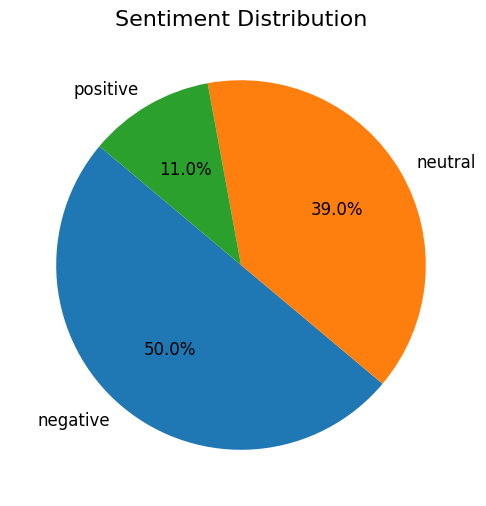

,name,username,description,location,followers,numberstatuses,time,tweets,Mentions,pagerank,community_louvain,Topic,sentiment
7741,Conflict Reporter,WarReporter1,Reporting on conflicts in the MENA and Asia re...,Worldwide contributions,946,379,2016-03-11 20:35:00,RT @Tails_live: Tails 2.2 is out: https://t.co...,[Tails_live],0.000596,15.0,6,neutral
6696,Mustafa Al Iraqi,moustiklash,NaN,NaN,842,113,2016-03-03 15:55:00,"The name ""Daesh"" was created by rafidha to sla...",[],0.000328,36.0,-1,negative
5812,War BreakingNews,warrnews,we provide fresh news from every battlefield,world,7184,6629,2016-02-26 13:44:00,RT @M3t4_tr0n: #FSA Mountain Hawks Brigade hit...,[M3t4_tr0n],0.000350,18.0,3,neutral
2878,War BreakingNews,warrnews,we provide fresh news from every battlefield,world,6894,6117,2016-02-04 09:38:00,ISIS threatens government supply route to #Ale...,[],0.000350,18.0,-1,negative
1827,Al-Battar English,Al_Battar_Engl,NaN,NaN,117,144,2016-01-29 15:32:00,#WilayatNinawa A Tour in Al-Bursa Market in #M...,[],0.000933,37.0,12,neutral


In [ ]:
# 4. Visualizzazione della distribuzione del sentiment
# Creiamo un conteggio delle occorrenze di ciascun tipo di sentiment
sentiment_counts = df_small["sentiment"].value_counts()

# Creazione di un grafico a torta per visualizzare i risultati
plt.figure(figsize=(8, 6))
plt.pie(
    sentiment_counts,  # Valori
    labels=sentiment_counts.index,  # Etichette (POSITIVE, NEUTRAL, NEGATIVE)
    autopct="%1.1f%%",  # Mostra le percentuali
    startangle=140,  # Rotazione iniziale
    textprops={"fontsize": 12},  # Dimensione del testo
)
plt.title("Sentiment Distribution", fontsize=16)  # Titolo del grafico
plt.show()  # Mostra il grafico


# zero-shot learning

Il sentiment è quello che ci serve? Sarebbe piu utile distinguere conversazioni pro o contro l organizzazione.. Come facciamo se non c'è un classificatore addestrato pronto su hugginface?

Ecco un approccio per implementare la classificazione di conversazioni "pro-ISIS", "contro-ISIS" o "neutre" utilizzando il zero-shot learning con un modello di linguaggio come Meta-Llama. Questo metodo consente di creare rapidamente un classificatore personalizzato senza bisogno di addestrare un modello dedicato.

1- Zero-Shot Learning:
* Consente al modello di classificare i tweet senza bisogno di un dataset preaddestrato. Si basa su istruzioni dettagliate fornite nel prompt, descrivendo esattamente cosa vogliamo che il modello faccia.


2- Prompting mirato:
* Usiamo un prompt chiaro per guidare il modello a scegliere tra tre categorie: "pro-ISIS", "contro-ISIS" e "neutro".

3- Vantaggi:
* Nessun addestramento necessario.
* Flessibilità per modificare le categorie o aggiungerne di nuove.


In [ ]:
import os
from together import Together
from tqdm import tqdm
import pandas as pd

# 1. Configurazione della chiave API
# Leggiamo la chiave API dal file per garantire la sicurezza della chiave
with open("/content/drive/MyDrive/Colab_Notebooks/OSINTItalia/api_key_tog.txt", "r") as file:
    api_key = file.read().strip()

# Impostiamo la chiave API come variabile di ambiente
os.environ["TOGETHER_API_KEY"] = api_key

# Inizializziamo il client Together AI per interagire con il modello
client = Together(api_key=os.environ.get("TOGETHER_API_KEY"))

# 2. Funzione per classificare un tweet
# Questa funzione utilizza il modello per classificare un tweet come "pro-ISIS", "contro-ISIS" o "neutro"
def classify_tweet(tweet):
    # Creiamo un prompt chiaro e mirato
    prompt = f"""
Sei un analista OSINT. Analizza il seguente tweet:
"{tweet}"
Classificalo come:
- "pro-ISIS" se il contenuto sostiene o promuove ISIS.
- "contro-ISIS" se il contenuto critica o si oppone a ISIS.
- "neutro" se il contenuto non esprime una posizione chiara.
Rispondi solo con una delle tre categorie.
    """
    # Inviamo il prompt al modello
    response = client.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",  # Specifica il modello da utilizzare
        prompt=prompt,  # Prompt definito sopra
        max_tokens=50,  # Numero massimo di token nella risposta
        temperature=0.3  # Controllo della creatività (più basso = più preciso)
    )
    # Estraiamo la classificazione dalla risposta del modello
    return response.choices[0].text.strip()

# 3. Configurazione di tqdm con pandas
# Questo ci permette di monitorare il progresso durante l'elaborazione
tqdm.pandas()

# 4. Creazione di un campione di tweet
# Selezioniamo un sottoinsieme casuale di tweet per velocizzare l'elaborazione
df_small = df.sample(100)

# 5. Applicazione della classificazione
# Applichiamo la funzione di classificazione a ciascun tweet del campione
df_small["classification"] = df_small["tweets"].progress_apply(classify_tweet)


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


In [ ]:
df_small[['username','tweets','classification']].head()

,username,tweets,classification
13233,al_zaishan10,#AmaqAgency \n#IslamicState \n#WilayatHalab \n...,- pro-ISIS
10359,wayyf44rer,Beirut buses provide rare bridge to IS turf ht...,Contro-ISIS.
3515,mobi_ayubi,RT @lion_faisal: USA has rewarded #Iran with 1...,Contro-ISIS.
7029,_IshfaqAhmad,Ramiz Raja you unbeauty. #AsiaCupT20Final,Neutro.
16718,Uncle_SamCoco,RT @SimNasr: A good read https://t.co/4BEqUWtGdl,Contro-ISIS.


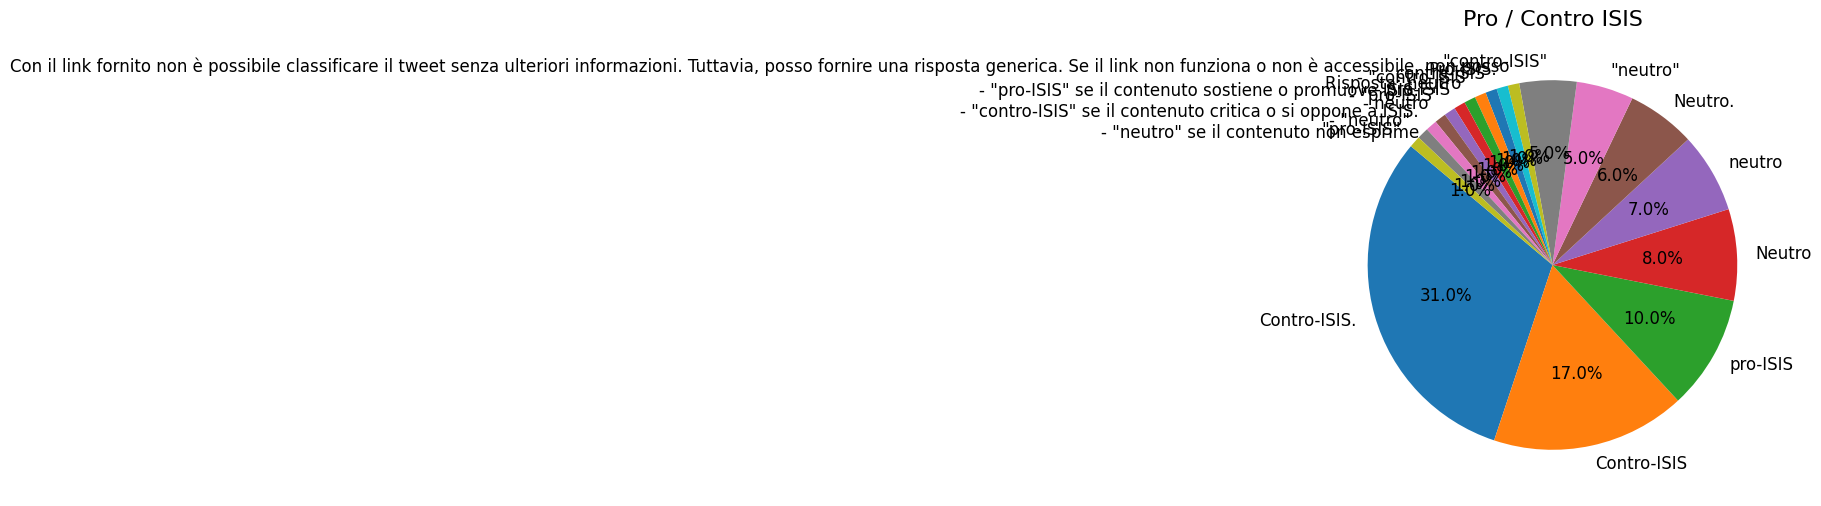

,name,username,description,location,followers,numberstatuses,time,tweets,Mentions,pagerank,community_louvain,Topic,sentiment,classification
13233,Aiman al-zaishan,al_zaishan10,NaN,NaN,24,164,2016-04-20 17:53:00,#AmaqAgency \n#IslamicState \n#WilayatHalab \n...,[],0.000291,30.0,-1,neutral,- pro-ISIS
10359,wayyf44rer,wayyf44rer,News of Maghreb and Mashreq,Middle of Nowhere,469,66,2016-03-31 19:02:00,Beirut buses provide rare bridge to IS turf ht...,[],0.000292,11.0,2,neutral,Contro-ISIS.
3515,Salahuddin Ayubi,mobi_ayubi,"Journalist, specialize in ongoing war against ...",NaN,739,6824,2016-02-07 21:44:00,RT @lion_faisal: USA has rewarded #Iran with 1...,[lion_faisal],0.000296,7.0,82,negative,Contro-ISIS.
7029,Ibni Haneefah,_IshfaqAhmad,Medico at GMC Srinagar • Pro-Khilafah • Anti-D...,اُمتِ مُسلمہ ولایت کشمیر,1649,13713,2016-03-06 17:59:00,Ramiz Raja you unbeauty. #AsiaCupT20Final,[],0.000371,36.0,38,negative,Neutro.
16718,كتكات كوكونت,Uncle_SamCoco,Here to defend the American freedom and also ...,"Texas, USA",1798,7028,2016-05-11 17:29:00,RT @SimNasr: A good read https://t.co/4BEqUWtGdl,[SimNasr],0.000364,9.0,4,positive,Contro-ISIS.


In [ ]:
# Conta il numero di occorrenze per ciascun sentiment
sentiment_counts = df_small["classification"].value_counts()

# Creazione della pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    textprops={"fontsize": 12},
)
plt.title("Pro / Contro ISIS", fontsize=16)
plt.show()

df_small.head()